## CatBoost

In [7]:
import sys
import os

import numpy as np
from tqdm import tqdm

import pandas as pd
from pymystem3 import Mystem
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

In [5]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

In [6]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

tf_idf = vectorizer.fit_transform(X.release)

CatBoost на наших данных обучается дольше, чем остальные бустинги, поэтому запустить перебор по полной сетке возможных значений с помощью optuna очень накладно по времени. Попытаемся аналитически подобрать гиперпараметры.

Сначала на параметрах по умолчанию посмотрим, какую максимальную глюбину дерева стоит рассматривать.

100%|██████████| 15/15 [4:59:25<00:00, 1197.72s/it]


<Axes: title={'center': 'Min on depth=11, iterations=68'}>

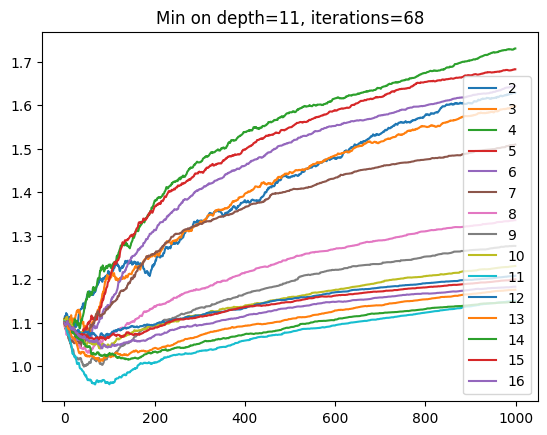

In [27]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, test_size=0.2, random_state=42)
eval_dataset = Pool(data=X_val, label=y_val)
res = []
for depth in tqdm(range(2, 17)):
    model = CatBoostClassifier(
        max_depth=depth,
        loss_function='MultiClass',
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
    res.append(model.evals_result_['validation']['MultiClass'])
res_arr = np.array(res)
ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
pd.DataFrame(res_arr.T, columns=range(2, 17)).plot(
    title=f"Min on depth={ij_min[0] + 2}, iterations={ij_min[1]}")

Видим, что на максимальной глубине 11, качество получается лучше. Будем использовать в дальнейнем подборе это значение.

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [1:14:47<00:00, 897.57s/it]   


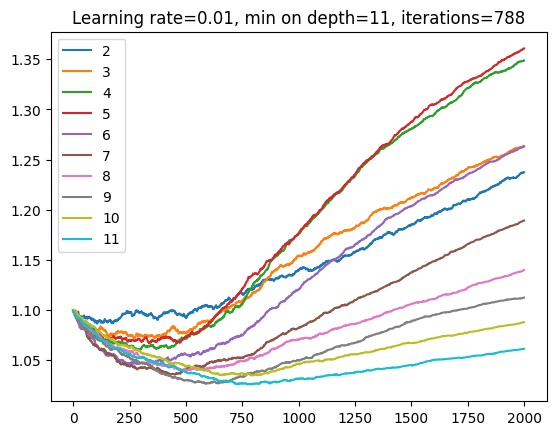

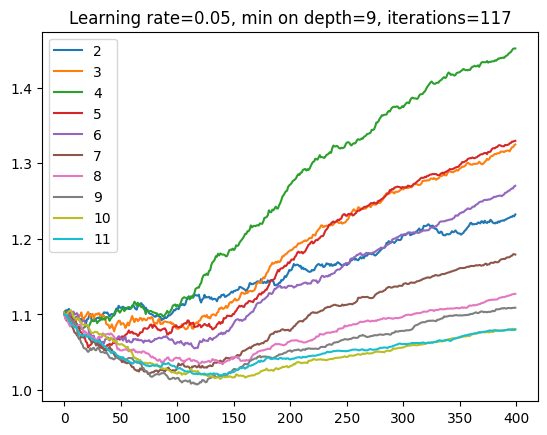

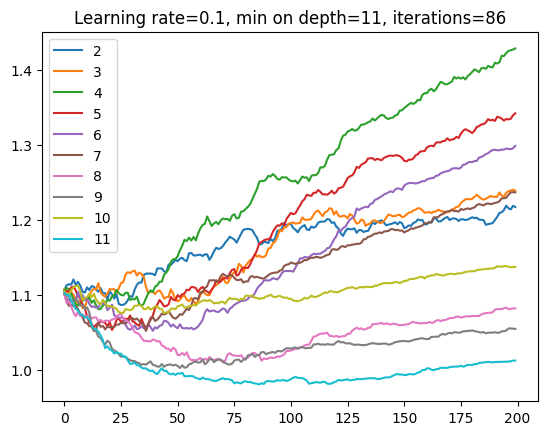

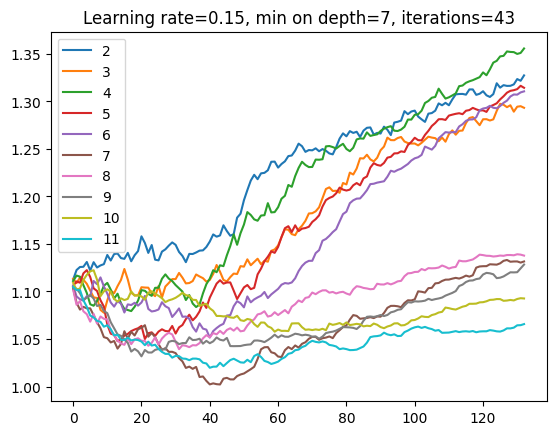

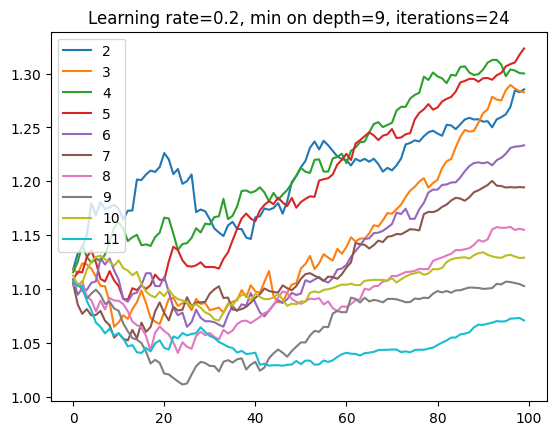

In [23]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y, test_size=0.2, random_state=42)
eval_dataset = Pool(data=X_val, label=y_val)
best_params = []
for lr in tqdm([0.01, 0.05, 0.1, 0.15, 0.2]):
    res = []
    for depth in range(2, 12):
        model = CatBoostClassifier(
            max_depth=depth,
            learning_rate=lr,
            iterations=int(20 / lr),
            loss_function='MultiClass',
            random_state=42
        )
        model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
        res.append(model.evals_result_['validation']['MultiClass'])
    res_arr = np.array(res)
    ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
    best_params.append({'lr': lr, 'depth': ij_min[0] + 2, 'iterations': ij_min[1], 'loss': res_arr[ij_min[0], ij_min[1]]})
    pd.DataFrame(res_arr.T, columns=range(2, 12)).plot(
        title=f"Learning rate={lr}, min on depth={ij_min[0] + 2}, iterations={ij_min[1]}")

In [25]:
df_best_params = pd.DataFrame(best_params)
df_best_params

,lr,depth,iterations,loss
0,0.01,11,788,1.025454
1,0.05,9,117,1.007480
2,0.10,11,86,0.981131
3,0.15,7,43,1.002135
4,0.20,9,24,1.011211


              precision    recall  f1-score   support

        -1.0       0.57      0.52      0.55        23
         0.0       0.42      0.58      0.48        26
         1.0       0.73      0.42      0.53        19

    accuracy                           0.51        68
   macro avg       0.57      0.51      0.52        68
weighted avg       0.56      0.51      0.52        68



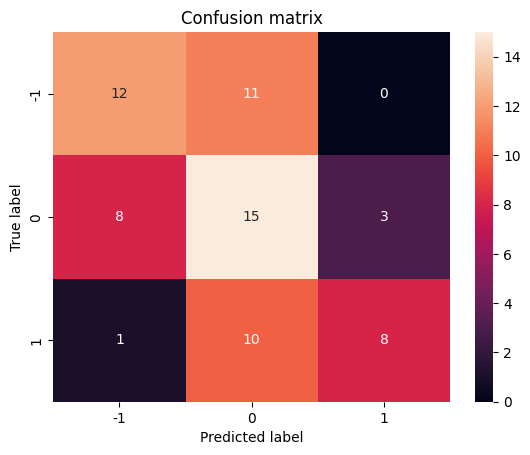

In [29]:
min_best_param = df_best_params[df_best_params['loss'] == df_best_params['loss'].min()]
model = CatBoostClassifier(
        max_depth=min_best_param['depth'].values[0],
        learning_rate=min_best_param['lr'].values[0],
        iterations=min_best_param['iterations'].values[0],
        loss_function='MultiClass',
        random_state=42,
        verbose=False
    )
metric, model = calc_metrics(
    tf_idf,
    y,
    model,
    name="TF-IDF CatBoost"
)

In [30]:
metric

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF CatBoost,0.514706,0.520886,0.506572,0.571789,0.701963,0.709235
